# Exploring PTT-PPG

Let's begin by exploring data in the Pulse Transit Time PPG dataset.

Our **objectives** are to:
- Understand what records are present in the dataset.
- Find out which signals are present in a record, and how long the signals last.
- Load waveforms using the WFDB toolbox.
- Plot the waveforms

<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the Pulse Transit Time PPG dataset <a href="https://physionet.org/content/pulse-transit-time-ppg/1.1.0/">here</a>.</p>
</div>

---
## Setup

### Specify the required Python packages
We'll import the following:
- _sys_: an essential python package
- _pathlib_ (well a particular function from _pathlib_, called _Path_)

In [1]:
import sys
from pathlib import Path

### Specify a particular version of the WFDB Toolbox

- _wfdb_: For this workshop we will be using version 4 of the WaveForm DataBase (WFDB) Toolbox package. The package contains tools for processing waveform data such as those found in this dataset:

In [2]:
!pip install wfdb==4.1.0
import wfdb

<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the WFDB package <a href="https://physionet.org/content/wfdb-python/4.1.0/">here</a>.</p>
</div>

Now that we have imported these packages (_i.e._ toolboxes) we have a set of tools (functions) ready to use.

### Specify the name of the Database

- Specify the name of the database on Physionet, which comes from the URL: https://physionet.org/content/pulse-transit-time-ppg/1.1.0/

In [3]:
database_name = 'pulse-transit-time-ppg/1.1.0'

---
## Identify the records in the database

### Get a list of records

- Use the [`get_record_list`](https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.get_record_list) function from the WFDB toolbox to get a list of records in the database.

In [5]:
record_list = wfdb.get_record_list(database_name)
print(f"The '{database_name}' database contains {len(record_list)} records")

The 'pulse-transit-time-ppg/1.1.0' database contains 66 records


### Look at the records

- Display the first few records

In [6]:
# format and print first six records
no_records = 6
first_records = [str(x) for x in record_list[0:no_records]]
first_records = "\n - ".join(first_records)
print(f"First records: \n - {first_records}")

print("""
Note the formatting of the record names:
 - subject (e.g. 's1')
 - activity (e.g. 'run')
 """)

First records: 
 - s1_walk
 - s1_run
 - s1_sit
 - s2_walk
 - s2_run
 - s2_sit

Note the formatting of the record names:
 - subject (e.g. 's1')
 - activity (e.g. 'run')
 


<div class="alert alert-block alert-info">
<p><b>Q:</b> Can you print the names of the last five records? <br> <b>Hint:</b> in Python, the last five elements can be specified using '[-5:]'</p>
</div>

---
## Extract metadata for a record

Each record contains metadata stored in a header file, named "`<record name>.hea`"

### Load the metadata for a record
- Use the [`rdheader`](https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.rdheader) function from the WFDB toolbox to load metadata from the record header file

In [8]:
idx = 3
record = record_list[idx]
record_data = wfdb.rdheader(record, pn_dir=database_name)
remote_url = "https://physionet.org/content/" + database_name + "/" + record + ".hea"
print(f"Done: metadata loaded for record '{record}' from the header file at:\n{remote_url}")

Done: metadata loaded for record 's2_walk' from the header file at:
https://physionet.org/content/pulse-transit-time-ppg/1.1.0/s2_walk.hea


---
## Inspect details of physiological signals recorded in this record
- Printing a few details of the signals from the extracted metadata

In [9]:
print(f"- Number of signals: {record_data.n_sig}".format())
print(f"- Duration: {record_data.sig_len/(record_data.fs*60):.1f} minutes") 
print(f"- Base sampling frequency: {record_data.fs} Hz")
print(f"\nThis record contains the following signals: {record_data.sig_name}")
print(f"\nThe signals are measured in units of: {record_data.units}")

- Number of signals: 18
- Duration: 8.2 minutes
- Base sampling frequency: 500 Hz

This record contains the following signals: ['ecg', 'pleth_1', 'pleth_2', 'pleth_3', 'pleth_4', 'pleth_5', 'pleth_6', 'lc_1', 'lc_2', 'temp_1', 'temp_2', 'temp_3', 'a_x', 'a_y', 'a_z', 'g_x', 'g_y', 'g_z']

The signals are measured in units of: ['mV', 'NU', 'NU', 'NU', 'NU', 'NU', 'NU', 'NU', 'NU', 'C', 'C', 'C', 'g', 'g', 'g', 'deg/s', 'deg/s', 'deg/s']


See [here](https://physionet.org/content/pulse-transit-time-ppg/1.1.0/#description) for definitions of signal abbreviations.

### Find out how long each signal lasts

All signals in a segment are time-aligned, measured at the same sampling frequency, and last the same duration:

In [10]:
print(f"The signals have a base sampling frequency of {record_data.fs:.1f} Hz")
print(f"and they last for {record_data.sig_len/(record_data.fs*60):.1f} minutes")

The signals have a base sampling frequency of 500.0 Hz
and they last for 8.2 minutes


## Identify records suitable for analysis

### Specify requirements

- Required signals

In [11]:
required_sigs = ['ecg', 'pleth_1']

- Required duration

In [12]:
# convert from minutes to seconds
req_seg_duration = 1*60 

- Required activity

In [13]:
req_activity = "sit"

### Find out how many records meet the requirements

In [19]:
matching_recs = {'dir':[], 'name':[], 'length':[], 'start_sbp':[], 'end_sbp':[], 'delta_sbp':[]}

for record in record_list:
    print('Record: {}'.format(record), end="", flush=True)
    
    # check whether this record corresponds to a suitable activity
    if not req_activity in record:
        print('   (not required activity)')
        continue

    record_data = wfdb.rdheader(record,
                                pn_dir=database_name,
                                rd_segments=True)

    # Check whether the required signals are present in the record
    sigs_present = record_data.sig_name
    if not all(x in sigs_present for x in required_sigs):
        print('   (missing signals)')
        continue

    seg_length = record_data.sig_len/(record_data.fs)

    if seg_length < req_seg_duration:
        print(f' (too short at {seg_length/60:.1f} mins)')
        continue
    
    # This record does meet the requirements, so extract information and data from it
    
    # Information
    matching_recs['dir'].append(database_name)
    matching_recs['name'].append(record_data.record_name)
    matching_recs['length'].append(seg_length)
    
    # Blood pressure measurements
    str_to_find = '<bp_sys_start>: '
    curr_len = len(str_to_find)
    start_el = record_data.comments[0].index(str_to_find) + curr_len
    str_to_find = '<bp_sys_end>'
    len(str_to_find)
    end_el = record_data.comments[0].index(str_to_find) - 1
    matching_recs['start_sbp'].append(int(record_data.comments[0][start_el:end_el]))
    str_to_find = '<bp_sys_end>: '
    curr_len = len(str_to_find)
    start_el = record_data.comments[0].index(str_to_find) + curr_len
    str_to_find = '<bp_dia_start>'
    len(str_to_find)
    end_el = record_data.comments[0].index(str_to_find) - 1
    matching_recs['end_sbp'].append(int(record_data.comments[0][start_el:end_el]))
    matching_recs['delta_sbp'].append(matching_recs['end_sbp'][-1]-matching_recs['start_sbp'][-1])

    print('   (met requirements)')

print(f"A total of {len(matching_recs['dir'])} out of {len(record_list)} records met the requirements.")

Record: s1_walk   (not required activity)
Record: s1_run   (not required activity)
Record: s1_sit   (met requirements)
Record: s2_walk   (not required activity)
Record: s2_run   (not required activity)
Record: s2_sit   (met requirements)
Record: s3_sit   (met requirements)
Record: s3_walk   (not required activity)
Record: s3_run   (not required activity)
Record: s4_sit   (met requirements)
Record: s4_run   (not required activity)
Record: s4_walk   (not required activity)
Record: s5_walk   (not required activity)
Record: s5_run   (not required activity)
Record: s5_sit   (met requirements)
Record: s6_run   (not required activity)
Record: s6_sit   (met requirements)
Record: s6_walk   (not required activity)
Record: s7_walk   (not required activity)
Record: s7_run   (not required activity)
Record: s7_sit   (met requirements)
Record: s8_sit   (met requirements)
Record: s8_run   (not required activity)
Record: s8_walk   (not required activity)
Record: s9_walk   (not required activity)
Record

<div class="alert alert-block alert-info">
<p><b>Question:</b> Is this enough data for a study? Consider different types of studies, e.g. assessing the performance of a previously proposed algorithm to estimate BP from the PPG signal, vs. developing a deep learning approach to estimate BP from the PPG.</p>
</div>

## Exploring the data

- Import the _matplotlib_ package for plotting

In [20]:
from matplotlib import pyplot as plt
import numpy as np

### Blood pressure measurements

- Display blood pressure measurements

Text(0, 0.5, 'Frequency')

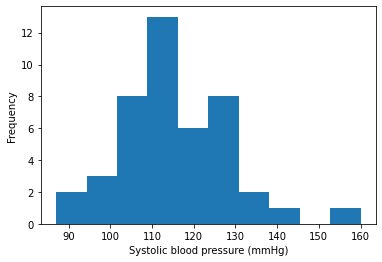

In [21]:
bp = np.concatenate((matching_recs['start_sbp'], matching_recs['end_sbp']))
plt.hist(bp)
plt.xlabel('Systolic blood pressure (mmHg)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

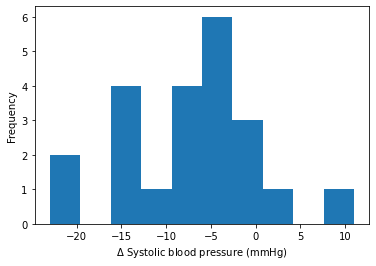

In [22]:
bp = matching_recs['delta_sbp']
plt.hist(bp)
plt.xlabel('$\Delta$ Systolic blood pressure (mmHg)')
plt.ylabel('Frequency')

- Display changes in blood pressure measurements between start and end of activity

### Inspect signals

In [93]:
start_seconds = 0
n_seconds_to_load = 60
rec_no = 0
record_name = matching_recs['name'][0]
record_dir = matching_recs['dir'][0]
record_data = wfdb.rdheader(record_name,
                            pn_dir=record_dir,
                            rd_segments=True)
fs = record_data.fs
sampfrom = fs * start_seconds
sampto = fs * (start_seconds + n_seconds_to_load)

segment_data = wfdb.rdrecord(record_name=record_name,
                             channel_names = ['ecg','pleth_2'],
                             sampfrom=sampfrom,
                             sampto=sampto,
                             pn_dir=record_dir)

print(f"{n_seconds_to_load} seconds of data extracted from segment: {record_name}")

60 seconds of data extracted from segment: s1_sit


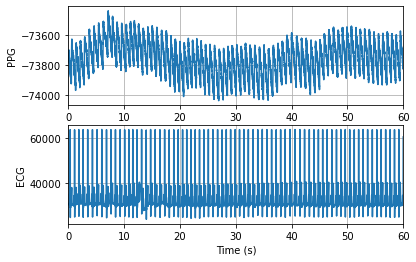

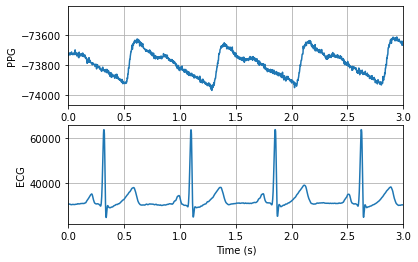

In [94]:
sig_no = segment_data.sig_name.index('pleth_2')
ppg = -1*segment_data.p_signal[:,sig_no]
fs = segment_data.fs
t = np.arange(0, (len(ppg) / fs), 1.0 / fs)

sig_no = segment_data.sig_name.index('ecg')
ecg = segment_data.p_signal[:,sig_no]

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, ppg)
axs[0].set_xlim(0, n_seconds_to_load)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('PPG')
axs[0].grid(True)

axs[1].plot(t, ecg)
axs[1].set_xlim(0, n_seconds_to_load)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('ECG')
axs[1].grid(True)

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, ppg)
axs[0].set_xlim(0, 3)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('PPG')
axs[0].grid(True)

axs[1].plot(t, ecg)
axs[1].set_xlim(0, 3)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('ECG')
axs[1].grid(True)


### Plot frequency spectra of signals

Now we're going to plot the frequency spectrum of the PPG signal.

In [138]:
from scipy import signal

- First, let's filter the signal to eliminate very low frequencies which would otherwise dominate the power spectrum.

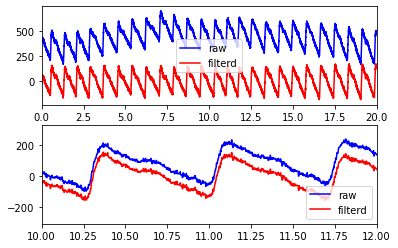

In [137]:
# Specify cutoffs in Hertz
hpf_cutoff = 0.5 

# create high-pass filter
sos_ppg = signal.butter(4,
                    hpf_cutoff,
                    btype = 'highpass',
                    analog = False,
                    output = 'sos',
                    fs = segment_data.fs)

#  high-pass filter
ppg_filt = signal.sosfiltfilt(sos_ppg, ppg)

# plot results
fig, axs = plt.subplots(2, 1)
axs[0].plot(t, 400+signal.detrend(ppg), color='blue', label='raw')
axs[0].plot(t, ppg_filt, color='red', label='filterd')
axs[0].set_xlim(0, 20)
axs[0].legend()

axs[1].plot(t, signal.detrend(ppg), color='blue', label='raw')
axs[1].plot(t, ppg_filt, color='red', label='filterd')
axs[1].set_xlim(10, 12)
axs[1].legend()

- Let's plot the frequency spectrum

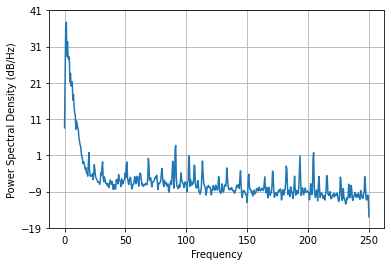

In [146]:
Pxx, freqs = plt.psd(ppg_filt, NFFT=1024, Fs=fs)

- Now let's focus on the lower, physiological frequencies, by downsampling the signal to a lower sampling frequency.

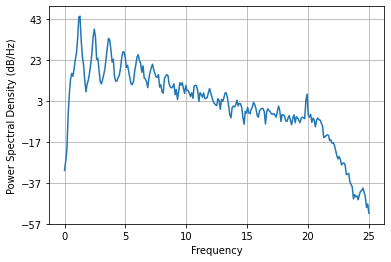

In [158]:
ds_fs = 50
ppg_ds = signal.decimate(ppg_filt, round(fs/ds_fs))
Pxx, freqs = plt.psd(ppg_ds, NFFT=512, Fs=ds_fs)

Note that this could also be done using scipy:

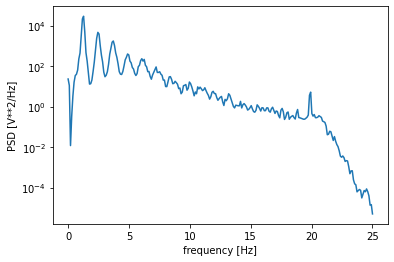

In [159]:
f, Pxx_spec = signal.welch(ppg_ds, ds_fs, nperseg=512)
plt.semilogy(f, Pxx_spec)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Most of the frequency content is below 7.5 Hz:

In [174]:
total_Pxx_spec = sum(Pxx_spec)
freq_no = 0
curr_sum = 0
while curr_sum < 0.99*total_Pxx_spec:
    curr_sum = curr_sum+Pxx_spec[freq_no]
    freq_no += 1

print('99% of the frequency content is below {} Hz'.format(f[freq_no]))


99% of the frequency content is below 7.32421875 Hz


- Let's repeat for the ECG:

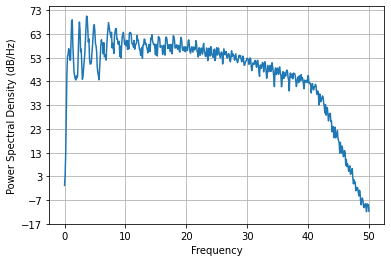

In [161]:
ecg_filt = signal.sosfiltfilt(sos_ppg, ecg)
ds_fs = 100
ecg_ds = signal.decimate(ecg_filt, round(fs/ds_fs))
Pxx, freqs = plt.psd(ecg_ds, NFFT=1024, Fs=ds_fs)

For the ECG, most of the frequency content is below 35 Hz:

In [175]:
f, Pxx_spec = signal.welch(ecg_ds, ds_fs, nperseg=1024)
total_Pxx_spec = sum(Pxx_spec)
freq_no = 0
curr_sum = 0
while curr_sum < 0.99*total_Pxx_spec:
    curr_sum = curr_sum+Pxx_spec[freq_no]
    freq_no += 1

print('99% of the frequency content is below {} Hz'.format(f[freq_no]))


99% of the frequency content is below 33.984375 Hz
